<a href="https://colab.research.google.com/github/Fanusaez/7506R-2C2022-GRUPO13/blob/sabado-1-10-2022/7506R_TP1_GRUPO13_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico 1 : Propiedades en Venta
## Grupo 13
### Integrantes:
- Ivan Manuel Pensado
- Axel Tomas Higa
- Edgardo Francisco Saez 
- Lautaro Barrionuevo
- Nicolás Carreño

# Importe de librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

import scipy.stats as st

: 

# Lectura de archivo

In [ ]:
ds_propiedades = pd.read_csv('properati_argentina_2021.csv')

: 

In [ ]:
ds_propiedades.head()

: 

: 

# Análisis Exploratorio y Preprocesamiento de Dato

***Filtrado inicial***

Se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

In [ ]:
ds_prop_filtrado = ds_propiedades[ds_propiedades.place_l2.str.contains('Capital Federal', case=False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_type.str.fullmatch('Departamento|Casa|ph', case = False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.operation.str.contains('venta', case=False, na =  False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_currency.str.contains('USD', case=False, na =  False)]  #Preguntar si el na va en true

: 

***Exploración inicial***

Tipo de variable

In [ ]:
ds_prop_filtrado.dtypes

: 

Variables Cuantitativas

In [ ]:
cuantitativos = ["latitud", "longitud", "property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_prop_filtrado.loc[:,cuantitativos]
ds_resumen_cuantitativo = pd.DataFrame()
ds_resumen_cuantitativo["media"] = ds_cuantitativo.mean()
ds_resumen_cuantitativo["mediana"] = ds_cuantitativo.median()
ds_resumen_cuantitativo["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_resumen_cuantitativo["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_resumen_cuantitativo["moda"] = ds_cuantitativo.mode().iloc[0]
ds_resumen_cuantitativo

: 

Variables Cualitativas

In [ ]:
cualitativos = ["place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_cualitativo = ds_prop_filtrado.loc[:,cualitativos]

: 

* Mostrar cantidad de valores posibles

In [ ]:
ds_cualitativo.nunique()

: 

* Mostrar frecuencias
    * Obviamos las opciones de un solo tipo porque la frecuencia es de 100%

In [ ]:
ds_cualitativo.place_l3.value_counts(normalize=True)* 100

: 

In [ ]:
ds_cualitativo.property_type.value_counts(normalize=True)* 100

: 

In [ ]:
ds_cualitativo.property_title.value_counts(normalize=True)* 100

: 

* Determinar variables irrelevantes en el análisis

Debido a que las caracteristicas cualitativas "place_l2", "operation", "Property_currency" solo poseen un valor posible, es irrelevante para el analisis de datos. Tambien la caracteristica de "Property_title" al ser una descripcion del vendedor no aporta mucha informacion analitica. Por ultimo, los datos que no aportan al analisis, son las fechas, de las columnas "Start_date", "End_date" y "Created_on" debido a que no se especifica que significa dichas fechas. 

In [ ]:
columnas_a_eliminar = ["id","place_l5","place_l6"] # variables irrelevantes, podrian ser: property_title place_l5	place_l6 y (start_date created_on) son lo mismo
ds_filtado_copia = ds_prop_filtrado.copy()
ds_filtado_copia.drop(columns = columnas_a_eliminar, inplace = True)

: 

* Realizar un análisis gráfico de las distribuciones de las variables

In [ ]:

#sns.pairplot(ds_filtado_copia)

: 

###Correlaciones existentes entre las variables




*   Analizar las correlaciones existentes entre las variables.



In [ ]:
ds_prop_filtrado.corr()

: 

Precio promedio de propiedad por Barrio

In [ ]:
ds_precio_prom = ds_prop_filtrado.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Cantidad de propiedades por barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

: 

# DATOS FALTANTES

Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset

In [ ]:
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

: 

In [ ]:
ds_porcentaje = ds_prop_filtrado.isna().sum()/filas_totales*100
ds_porcentaje = ds_porcentaje.sort_values(ascending=False)
grf_ds = ds_porcentaje.plot.bar(alpha=0.5 , title="Gráfico de barras del porcetaje de datos faltantes sobre total " , xlabel="Columna" , ylabel="Porcentaje")

: 

Tomando en cuenta estos resultados, decidimos eliminar las columnas l4 , l5 y l6 debido a que el porcentaje de datos faltantes es total o casi total.

In [ ]:
columnas_a_eliminar = ["place_l4","place_l5","place_l6","id"]
ds_prop_filtrado.drop(columns = columnas_a_eliminar, inplace = True)

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.

In [ ]:
pd.DataFrame(ds_prop_filtrado).isna().sum(axis=1)



: 

Determinar, de ser posible, estrategias para reparar los valores faltantes.

Primero imputaremos los datos cuantitativos faltantes utilizando el metodo MICE.

In [ ]:
ds_prop_filtrado = ds_prop_filtrado[~ds_prop_filtrado["latitud"].isna() & ~ds_prop_filtrado["place_l3"].isna()]

: 

In [ ]:

copia_pre_imputacion= ds_prop_filtrado.copy()
mice = ds_prop_filtrado.copy()
#mice= mice[~mice["latitud"].isna() & ~mice["place_l3"].isna()]
columnas=['property_surface_total','property_surface_covered','property_rooms','property_price','property_bedrooms','latitud','longitud'] #,'property_surface_covered','property_bathrooms','property_rooms'
df_eliminar_nans_op3=ds_prop_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0,imputation_order='roman',initial_strategy = "mean") #imputation_order='roman'
df_eliminar_nans_op3_completo=imp.fit_transform(df_eliminar_nans_op3)
mice['property_surface_total']= df_eliminar_nans_op3_completo[:,0]
mice['property_surface_covered']=df_eliminar_nans_op3_completo[:, 1]
mice['property_rooms']= df_eliminar_nans_op3_completo[:, 2]
mice['property_price']= df_eliminar_nans_op3_completo[:, 3]
mice['property_bedrooms'] = df_eliminar_nans_op3_completo[:,4]
#mice['latitud'] = df_eliminar_nans_op3_completo[:,5]
#mice['longitud'] = df_eliminar_nans_op3_completo[:,6]
#mice['latitud'].drop()
#mice['longitud'].drop()


: 

In [ ]:
filas_totales=mice.shape[0]
print(mice.isna().sum()/filas_totales*100)

: 

Y luego procedemos imputando los cualitativos, que en este caso solo es el place_l3

In [ ]:
ds_barrios = pd.read_csv('barrios.csv', header=0,sep=';')

: 

In [ ]:
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import wkt
ds_barrios.WKT = ds_barrios.WKT



: 

Utilizaremos un archivo csv proporcionado por el gobierno de la Ciudad Autonoma de Buenos Aires, el cual nos proporcionorá el nombre de la localidad usando latitud y longitud, mediante la utilizacion de Polygon.

In [ ]:
for index, registro_prop in mice.iterrows():
    if  type(registro_prop["place_l3"]) is str:
        continue
    for index_, registro_barrio in ds_barrios.iterrows():
        if wkt.loads(registro_barrio.WKT).covers(Point(registro_prop.longitud,registro_prop.latitud)):
            barrio_aux = registro_barrio['BARRIO']
            mice['place_l3'][index] = barrio_aux

: 

In [ ]:
# ds_prop_filtrado.where(ds_prop_filtrado.place_l3.isna(), ds_barrios)

#ds_prop_filtrado["place_l3"].fillna(ds_barrios[ds_barrios["WKT"].contains(Point((ds_prop_filtrado.longitud,ds_prop_filtrado.latitud))) == True].barrio)
#ds_prop_filtrado["place_l3"].isna().combine_first()

: 

In [ ]:
filas_totales=mice.shape[0]
print(mice.isna().sum()/filas_totales*100)

: 

Luego logramos reducir el porcentaje de datos faltantes a 0.21
Investigando, descubrimos que los registros que aun tienen dato faltante, es porque la latitud y longitud no coinciden con un punto ubicado en CABA.

En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.

In [ ]:
mice[mice["property_price"]<0]

: 

In [ ]:
grf=sns.boxplot(y="property_price", data=copia_pre_imputacion[copia_pre_imputacion["property_price"]<500000])


: 

# analizar la existencia de valores atípicos


In [ ]:
#Calulo el vector de medias
"""
mice= mice[:300]
vmedias=np.mean(mice[['property_price','property_rooms']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = mice[['property_price','property_rooms']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=mice[['property_price','property_rooms']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

mice['mahalanobis']=mahal.diagonal()
mice.head
"""

: 

### Detectar valores atípicos en los datos en forma univariada

In [ ]:
ds_atipicos = mice.copy()
columnas_a_eliminar = ["start_date", "end_date", "created_on", "latitud", "longitud", "place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_atipicos.drop(columns = columnas_a_eliminar, inplace=True)

: 

property_rooms

In [ ]:
#z-score Rooms con librería stats
ds_atipicos['z_rooms']=st.zscore(ds_atipicos.property_rooms) #Agregamos columna con valores de z-score

#z-score modificado Rooms con librería stats
mediana_rooms = np.median(ds_atipicos.property_rooms)
MAD=np.median(np.absolute(ds_atipicos.property_rooms - mediana_rooms)) #Mediana de los desvios absolutos
df['zm_rooms']=(ds_atipicos.property_rooms - mediana_rooms)*0.6745/MAD

: 

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro"

In [ ]:
ds_atipicos[ds_atipicos['z_rooms'] > 3 ]

In [196]:
ds_atipicos[ds_atipicos['z_rooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms


In [ ]:
ds_atipicos[ds_atipicos['z_rooms'] > 3.5 ]

In [ ]:
ds_atipicos[ds_atipicos['zm_rooms'] < -3.5 ]

<AxesSubplot:ylabel='property_rooms'>

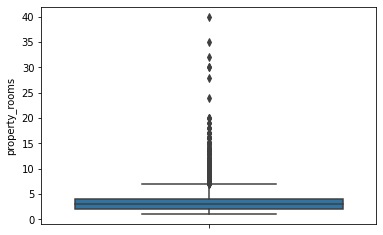

In [201]:
sns.boxplot(y=ds_atipicos.property_rooms)

property_bedrooms

In [199]:
#z-score
ds_atipicos['z_bedrooms']=st.zscore(ds_atipicos.property_bedrooms)

#z-score modificado
mediana_bedrooms = np.median(ds_atipicos.property_bedrooms)
MAD=np.median(np.absolute(ds_atipicos.property_bedrooms - mediana_bedrooms)) #Mediana de los desvios absolutos
df['zm_bedrooms']=(ds_atipicos.property_bedrooms - mediana_bedrooms)*0.6745/MAD

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,z_bedrooms
58,10.000000,10.000000,394.000000,244.0,500000.0,5.021059,7.018923
1140,16.073463,11.233571,10500.000000,10500.0,9900000.0,9.273181,8.082551
1932,13.205532,10.425275,186272.687314,217000.0,250000.0,7.265300,7.385610
3071,15.000000,15.000000,355.000000,215.0,220000.0,8.521634,11.330100
6922,12.053459,10.000000,864.708359,750.0,1500000.0,6.458716,7.018923
...,...,...,...,...,...,...,...
426287,12.000000,9.000000,558.000000,418.0,850000.0,6.421289,6.156687
438314,20.000000,14.464887,1019.000000,1019.0,820000.0,12.022209,10.868707
451439,10.000000,9.000000,240.000000,227.0,370000.0,5.021059,6.156687
458873,12.000000,12.000000,820.000000,820.0,550000.0,6.421289,8.743394


In [ ]:
ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ]

In [202]:
ds_atipicos[ds_atipicos['z_bedrooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,z_bedrooms


In [ ]:
ds_atipicos[ds_atipicos['zm_bedrooms'] > 3.5 ]

In [ ]:
ds_atipicos[ds_atipicos['z_bedrooms'] < -3.5 ]

<AxesSubplot:ylabel='property_bedrooms'>

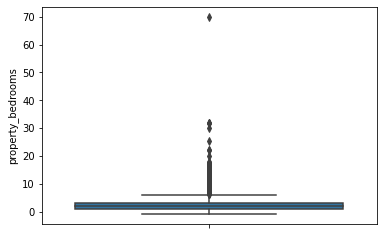

In [203]:
sns.boxplot(y=ds_atipicos.property_bedrooms)

property_surface_total

In [ ]:
#z-score
ds_atipicos['z_surface_total']=st.zscore(ds_atipicos.property_surface_total)

#z-score modificado
mediana_surface = np.median(ds_atipicos.property_surface_total)
MAD=np.median(np.absolute(ds_atipicos.property_surface_total - mediana_surface)) #Mediana de los desvios absolutos
df['zm_surface_total']=(ds_atipicos.property_surface_total - mediana_surface)*0.6745/MAD

In [ ]:
ds_atipicos[ds_atipicos['z_surface_total'] > 3 ]

In [ ]:
ds_atipicos[ds_atipicos['z_surface_total'] < -3 ]

In [ ]:
ds_atipicos[ds_atipicos['zm_surface_total'] > 3.5 ]

In [ ]:
ds_atipicos[ds_atipicos['zm_surface_total'] < -3.5 ]

<AxesSubplot:ylabel='property_surface_total'>

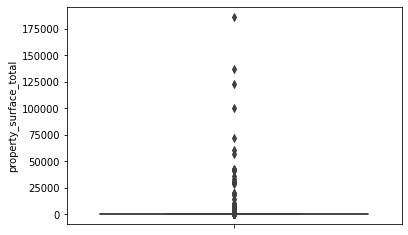

In [205]:
sns.boxplot(y=ds_atipicos.property_surface_total)

property_surface_covered

In [ ]:
#z-score
ds_atipicos['z_surface_covered']=st.zscore(ds_atipicos.property_surface_covered)

#z-score modificado
mediana_surface_covered = np.median(ds_atipicos.property_surface_covered)
MAD=np.median(np.absolute(ds_atipicos.property_surface_covered - mediana_surface_covered)) 
df['zm_surface_covered']=(ds_atipicos.property_surface_covered - mediana_surface_covered)*0.6745/MAD

In [ ]:
ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ]

In [ ]:
ds_atipicos[ds_atipicos['z_surface_covered'] < -3 ]

In [ ]:
ds_atipicos[ds_atipicos['zm_surface_covered'] > 3.5 ]

In [ ]:
ds_atipicos[ds_atipicos['zm_surface_covered'] < -3.5 ]

<AxesSubplot:ylabel='property_surface_covered'>

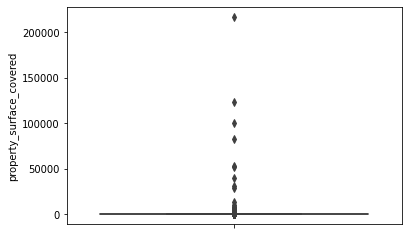

In [207]:
sns.boxplot(y=ds_atipicos.property_surface_covered)

property_price

In [208]:
#z-score
ds_atipicos['z_price']=st.zscore(ds_atipicos.property_price)

#z-score modificado
mediana_price = np.median(ds_atipicos.property_price)
MAD=np.median(np.absolute(ds_atipicos.property_price - mediana_price)) 
df['zm_price']=(ds_atipicos.property_price - mediana_price)*0.6745/MAD

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,z_bedrooms,z_surface_total,z_surface_covered,z_price
410,6.501154,4.0,400.0,253.630938,2700000.0,2.571464,1.845510,0.254712,0.167324,7.906365
411,6.501154,4.0,400.0,253.630938,2700000.0,2.571464,1.845510,0.254712,0.167324,7.906365
438,4.000000,3.0,282.0,256.000000,2250000.0,0.820368,0.983275,0.151022,0.169706,6.469897
448,5.000000,4.0,304.0,294.000000,1200000.0,1.520483,1.845510,0.170354,0.207927,3.118138
629,4.000000,3.0,214.0,196.000000,1200000.0,0.820368,0.983275,0.091268,0.109358,3.118138
...,...,...,...,...,...,...,...,...,...,...
459724,8.000000,3.0,285.0,272.000000,1250000.0,3.620828,0.983275,0.153658,0.185799,3.277746
459729,6.000000,3.0,271.0,265.000000,1250000.0,2.220598,0.983275,0.141356,0.178759,3.277746
459755,8.000000,5.0,431.0,415.000000,2800000.0,3.620828,2.707746,0.281953,0.329631,8.225580
459764,8.000000,4.0,383.0,383.000000,1700000.0,3.620828,1.845510,0.239774,0.297445,4.714214


In [ ]:
ds_atipicos[ds_atipicos['z_price'] > 3 ]

In [ ]:
ds_atipicos[ds_atipicos['z_price'] < -3 ]

In [ ]:
ds_atipicos[ds_atipicos['zm_price'] > 3.5 ]

In [ ]:
ds_atipicos[ds_atipicos['zm_price'] < -3.5 ]

<AxesSubplot:ylabel='property_price'>

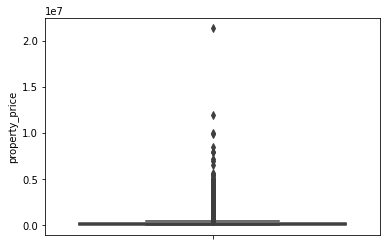

In [210]:
sns.boxplot(y=ds_atipicos.property_price)